# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based machine learning models in order to find the one that predicts STM transit delays with the best accuracy. The featured models are XGBoost, LightGBM and CatBoost, because they are more suitable for large datasets with mixed data and high cardinality.

## Data Description

`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`route_direction_North`, `route_direction_South`, `route_direction_West`: Route direction in degrees.<br>
`route_type_Night`, `route_type_HighFrequency` : One-Hot features for types of bus lines<br>
`stop_location_group`: Stop cluster based on coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`trip_phase_middle`, `trip_phase_end`: One-Hot feature for trip progress.<br>
`exp_delay_prev_stop`: Expected duration between the previous and current stop, in seconds.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`sch_rel_Scheduled`: One-Hot feature for schedule relationship.<br>
`time_of_day_evening`, `time_of_day_morning`, `time_of_day_night`: One-Hot features for time of day.<br>
`is_peak_hour`: Boolean value indicating if the sheduled arrival time is at peak hour.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`hist_avg_delay`: Historical delay per stop and hour, in seconds.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.<br>

## Imports

In [ ]:
from catboost import CatBoostRegressor
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import xgboost as xgb

In [2]:
# Load data
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (1000000, 25)


## Split the data

In [3]:
# Separate features from target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [4]:
# Train-validation-test split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

del X_temp
del y_temp

**Scaling**

Since only tree-based models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Fit Base Models

All models allow to setup a number of rounds and early stopping. To start, all models will run 100 rounds with an early stopping of 3.

In [5]:
# Create dataframe to track metrics
reg_metrics_df = pd.DataFrame(columns=['model', 'MAE', 'RMSE', 'R²'])

In [6]:
def add_reg_metrics(reg_metrics_df:pd.DataFrame, y_pred:pd.Series, y_true:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_true, y_pred)
	rmse = root_mean_squared_error(y_true, y_pred)
	r2 = r2_score(y_true, y_pred)

	reg_metrics_df.loc[len(reg_metrics_df)] = [model_name, mae, rmse, r2]
	return reg_metrics_df

### XGBoost

In [7]:
# Create regression matrices
xg_train_data = xgb.DMatrix(X_train, y_train, enable_categorical=False)
xg_val_data = xgb.DMatrix(X_val, y_val, enable_categorical=False)
xg_test_data = xgb.DMatrix(X_test, y_test, enable_categorical=False)
xg_eval_set = [(xg_train_data, 'train'), (xg_val_data, 'validation')]
xg_test_set = [(xg_train_data, 'train'), (xg_test_data, 'test')]

In [8]:
# Train model
xg_reg_base = xgb.train(
  params= {'objective': 'reg:squarederror', 'tree_method': 'hist'},
  dtrain=xg_train_data,
  num_boost_round=100,
  evals=xg_eval_set,
  verbose_eval=10,
  early_stopping_rounds=3
)

[0]	train-rmse:152.31019	validation-rmse:153.91902
[10]	train-rmse:144.36168	validation-rmse:145.99581
[20]	train-rmse:142.05614	validation-rmse:143.94414
[30]	train-rmse:140.49712	validation-rmse:142.68225
[40]	train-rmse:139.19469	validation-rmse:141.52439
[50]	train-rmse:137.96011	validation-rmse:140.50770
[60]	train-rmse:136.85269	validation-rmse:139.57915
[70]	train-rmse:136.30491	validation-rmse:139.21015
[80]	train-rmse:135.62900	validation-rmse:138.73844
[90]	train-rmse:134.90985	validation-rmse:138.18324
[99]	train-rmse:134.50138	validation-rmse:137.95417


In [10]:
# Evaluate model
y_pred = xg_reg_base.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,74.113609,137.954172,0.243022


**MAE**<br>
On average, the predictions are off by 74 seconds, which is not very good.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 24.3% of the variance, which is not good but understandable because of how random transit delays can be (bad weather, vehicle breakdown, accidents, etc.)

### LightGBM

In [11]:
# Train model
lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data)
lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

lgb_reg_base = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': -1
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=3)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 24
[LightGBM] [Info] Start training from score 54.673396
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 144.38


In [13]:
# Evaluate model
y_pred = lgb_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,74.113609,137.954172,0.243022
1,lgb_reg_base,77.483866,144.380113,0.170859


Overall, the LightGBM model performs worse than XGBoost.

### CatBoost

In [14]:
# Fit model
cat_reg_base = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=10,
    random_seed=42,
    verbose=10
)

cat_reg_base.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=3)

0:	learn: 156.1481234	test: 157.7748679	best: 157.7748679 (0)	total: 273ms	remaining: 27s
10:	learn: 150.9537028	test: 152.4911934	best: 152.4911934 (10)	total: 2.06s	remaining: 16.7s
20:	learn: 148.3832117	test: 149.8948033	best: 149.8948033 (20)	total: 3.71s	remaining: 14s
30:	learn: 146.9645721	test: 148.4588247	best: 148.4588247 (30)	total: 5.24s	remaining: 11.7s
40:	learn: 145.9591705	test: 147.5045417	best: 147.5045417 (40)	total: 6.72s	remaining: 9.67s
50:	learn: 145.1778538	test: 146.7427315	best: 146.7427315 (50)	total: 8.18s	remaining: 7.86s
60:	learn: 144.6237132	test: 146.2033472	best: 146.2033472 (60)	total: 10s	remaining: 6.42s
70:	learn: 144.2492241	test: 145.8488858	best: 145.8488858 (70)	total: 12.2s	remaining: 4.96s
80:	learn: 143.8539107	test: 145.4818850	best: 145.4818850 (80)	total: 14s	remaining: 3.29s
90:	learn: 143.3927604	test: 145.0213433	best: 145.0213433 (90)	total: 15.8s	remaining: 1.56s
99:	learn: 143.0129756	test: 144.6764796	best: 144.6764796 (99)	total:

In [15]:
# Evaluate model
y_pred = cat_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,74.113609,137.954172,0.243022
1,lgb_reg_base,77.483866,144.380113,0.170859
2,cat_reg_base,77.259533,144.676480,0.167452


CatBoost performs almost like LightGBM. Without hyperparameter tuning, XGBoost seems to capture a bit more of the underlying patterns than the two other models.

## Hyperparameter Tuning

### XGBoost

In [16]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time= 1.3min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=0.8; total time= 1.7min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=0.8; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  55.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  56.3s
[CV] END colsampl

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [17]:
# Best model
xg_best_model = random_search.best_estimator_
xg_best_params = random_search.best_params_

In [18]:
# Train best model with more boost rounds
xg_reg_tuned = xgb.train(
  params= {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'max_depth': xg_best_params['max_depth'],
    'learning_rate': xg_best_params['learning_rate'],
    'subsample': xg_best_params['subsample'],
    'colsample_bytree': xg_best_params['colsample_bytree'],
  },
  dtrain=xg_train_data,
  num_boost_round=10000,
  evals=xg_eval_set,
  verbose_eval=50,
  early_stopping_rounds=50
)

[0]	train-rmse:155.00360	validation-rmse:156.64241
[50]	train-rmse:140.64103	validation-rmse:142.92289
[100]	train-rmse:137.95297	validation-rmse:140.79927
[150]	train-rmse:135.05417	validation-rmse:138.62464
[200]	train-rmse:132.86165	validation-rmse:136.95970
[250]	train-rmse:131.28695	validation-rmse:136.00916
[300]	train-rmse:130.05956	validation-rmse:135.43072
[350]	train-rmse:128.80327	validation-rmse:134.75163
[400]	train-rmse:127.66209	validation-rmse:134.19110
[450]	train-rmse:126.85258	validation-rmse:133.95077
[500]	train-rmse:126.05603	validation-rmse:133.65182
[550]	train-rmse:125.26987	validation-rmse:133.42002
[600]	train-rmse:124.38533	validation-rmse:133.04339
[650]	train-rmse:123.63803	validation-rmse:132.73609
[700]	train-rmse:122.91130	validation-rmse:132.44905
[750]	train-rmse:122.30412	validation-rmse:132.28948
[800]	train-rmse:121.78978	validation-rmse:132.22545
[850]	train-rmse:121.24676	validation-rmse:132.09031
[900]	train-rmse:120.84793	validation-rmse:132.08

In [19]:
# Evaluate model
y_pred = xg_reg_tuned.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,74.113609,137.954172,0.243022
1,lgb_reg_base,77.483866,144.380113,0.170859
2,cat_reg_base,77.259533,144.676480,0.167452
3,xg_reg_tuned,70.514811,131.767074,0.309399


There's a significant improvement from the base XGBoost model.

### LightGBM

In [20]:
param_dist = {
  'n_estimators': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [5, 10, 15],
  'num_leaves': [20, 31, 40],
  'min_child_samples': [10, 20, 30],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 24
[LightGBM] [Info] Start training from score 54.963787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the 

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [20, 31, 40],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [21]:
# Best model
lgb_best_model = random_search.best_estimator_
lgb_best_params = random_search.best_params_

In [22]:
# Train model with more boost rounds and early stopping
lgb_reg_tuned = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': lgb_best_params['n_estimators'],
        'learning_rate': lgb_best_params['learning_rate'],
        'max_depth': lgb_best_params['max_depth'],
        'num_leaves': lgb_best_params['num_leaves'],
        'min_child_samples': lgb_best_params['min_child_samples'],
        'subsample': lgb_best_params['subsample'],
        'colsample_bytree': lgb_best_params['colsample_bytree']
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=10000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 24
[LightGBM] [Info] Start training from score 54.673396
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 130.435


In [23]:
# Evaluate model
y_pred = lgb_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,74.113609,137.954172,0.243022
1,lgb_reg_base,77.483866,144.380113,0.170859
2,cat_reg_base,77.259533,144.676480,0.167452
3,xg_reg_tuned,70.514811,131.767074,0.309399
4,lgb_reg_tuned,70.549666,130.435233,0.323289


The MAE is slightly better than the previous model and it's much better than the base LightGBM Model. This is the best performing model so far.

### CatBoost

In [24]:
param_dist = {
  'iterations': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [1, 3, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bagging_temperature=1, border_count=64, depth=8, iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=  29.6s
[CV] END bagging_temperature=1, border_count=64, depth=8, iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time=  29.7s
[CV] END bagging_temperature=1, border_count=32, depth=10, iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=  44.2s
[CV] END bagging_temperature=1, border_count=32, depth=10, iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time=  44.4s
[CV] END bagging_temperature=5, border_count=32, depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=  37.3s
[CV] END bagging_temperature=5, border_count=32, depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=  38.2s
[CV] END bagging_temperature=0, border_count=64, depth=10, iterations=500, l2_leaf_reg=3, learning_rate=0.05; total time= 4.0min
[CV] END bagging_temperature=0, border_count

RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x1259bb250>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1, 5],
                                        'border_count': [32, 64, 128],
                                        'depth': [6, 8, 10],
                                        'iterations': [100, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [25]:
# Best model
cat_best_model = random_search.best_estimator_
cat_best_params = random_search.best_params_

In [26]:
# Train best model with more iterations
cat_reg_tuned = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    border_count=cat_best_params['border_count'],
    bagging_temperature=cat_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_tuned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

0:	learn: 156.1568850	test: 157.7989199	best: 157.7989199 (0)	total: 202ms	remaining: 33m 38s
50:	learn: 145.4596387	test: 147.0610485	best: 147.0610485 (50)	total: 4.92s	remaining: 15m 58s
100:	learn: 143.0178042	test: 144.7634200	best: 144.7634200 (100)	total: 11s	remaining: 18m 2s
150:	learn: 140.9264662	test: 142.8673505	best: 142.8673505 (150)	total: 16.8s	remaining: 18m 17s
200:	learn: 139.4774201	test: 141.5402652	best: 141.5402652 (200)	total: 22.7s	remaining: 18m 28s
250:	learn: 138.1688034	test: 140.3976160	best: 140.3976160 (250)	total: 28s	remaining: 18m 7s
300:	learn: 136.9718755	test: 139.3819941	best: 139.3819941 (300)	total: 33.8s	remaining: 18m 9s
350:	learn: 135.9652068	test: 138.5566231	best: 138.5566231 (350)	total: 39.7s	remaining: 18m 12s
400:	learn: 135.0163114	test: 137.8529193	best: 137.8529193 (400)	total: 45.3s	remaining: 18m 4s
450:	learn: 134.1605033	test: 137.1816227	best: 137.1816227 (450)	total: 50.9s	remaining: 17m 57s
500:	learn: 133.3475964	test: 136.

Exception ignored in: <function ResourceTracker.__del__ at 0x105cbf7e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10928f7e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

750:	learn: 130.2951699	test: 134.1322914	best: 134.1322914 (750)	total: 1m 24s	remaining: 17m 20s
800:	learn: 129.7820753	test: 133.7636187	best: 133.7636187 (800)	total: 1m 30s	remaining: 17m 15s
850:	learn: 129.2930480	test: 133.4019763	best: 133.4019763 (850)	total: 1m 35s	remaining: 17m 8s
900:	learn: 128.8053868	test: 133.0610406	best: 133.0610406 (900)	total: 1m 41s	remaining: 17m 1s
950:	learn: 128.3939233	test: 132.7877244	best: 132.7877244 (950)	total: 1m 46s	remaining: 16m 57s
1000:	learn: 127.9843018	test: 132.5492681	best: 132.5470591 (999)	total: 1m 52s	remaining: 16m 51s
1050:	learn: 127.6399913	test: 132.3583382	best: 132.3583382 (1050)	total: 1m 57s	remaining: 16m 43s
1100:	learn: 127.2453912	test: 132.1020133	best: 132.1020133 (1100)	total: 2m 3s	remaining: 16m 36s
1150:	learn: 126.8617008	test: 131.8802241	best: 131.8802241 (1150)	total: 2m 8s	remaining: 16m 30s
1200:	learn: 126.4970086	test: 131.6669759	best: 131.6669759 (1200)	total: 2m 14s	remaining: 16m 22s
1250:

Exception ignored in: <function ResourceTracker.__del__ at 0x102b5f7e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


1900:	learn: 122.6149198	test: 129.6677316	best: 129.6677316 (1900)	total: 3m 30s	remaining: 14m 58s


Exception ignored in: <function ResourceTracker.__del__ at 0x1091077e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1052a77e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

1950:	learn: 122.4108596	test: 129.5736370	best: 129.5732523 (1949)	total: 3m 37s	remaining: 14m 56s
2000:	learn: 122.1675637	test: 129.4643482	best: 129.4627576 (1998)	total: 3m 42s	remaining: 14m 50s


Exception ignored in: <function ResourceTracker.__del__ at 0x102c437e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102c2f7e0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

2050:	learn: 121.9462613	test: 129.3638377	best: 129.3638377 (2050)	total: 3m 48s	remaining: 14m 46s
2100:	learn: 121.6936438	test: 129.2012342	best: 129.2012342 (2100)	total: 3m 54s	remaining: 14m 41s
2150:	learn: 121.4814289	test: 129.1369313	best: 129.1369313 (2150)	total: 4m	remaining: 14m 36s
2200:	learn: 121.2668403	test: 129.0484710	best: 129.0484710 (2200)	total: 4m 6s	remaining: 14m 32s
2250:	learn: 121.0475963	test: 128.9468157	best: 128.9468157 (2250)	total: 4m 13s	remaining: 14m 34s
2300:	learn: 120.8526166	test: 128.8962938	best: 128.8962938 (2300)	total: 4m 20s	remaining: 14m 32s
2350:	learn: 120.6624726	test: 128.8272036	best: 128.8251514 (2346)	total: 4m 27s	remaining: 14m 28s
2400:	learn: 120.4839380	test: 128.7865685	best: 128.7865685 (2400)	total: 4m 32s	remaining: 14m 23s
2450:	learn: 120.2959495	test: 128.7174488	best: 128.7174488 (2450)	total: 4m 38s	remaining: 14m 17s
2500:	learn: 120.1152514	test: 128.6633376	best: 128.6633376 (2500)	total: 4m 44s	remaining: 14m

In [27]:
# Evaluate model
y_pred = cat_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,74.113609,137.954172,0.243022
1,lgb_reg_base,77.483866,144.380113,0.170859
2,cat_reg_base,77.259533,144.676480,0.167452
3,xg_reg_tuned,70.514811,131.767074,0.309399
4,lgb_reg_tuned,70.549666,130.435233,0.323289
5,cat_reg_tuned,68.338418,127.482498,0.353580


In [28]:
# Get model with lowest RMSE
reg_metrics_df.nsmallest(n=1, columns='RMSE')

,model,MAE,RMSE,R²
5,cat_reg_tuned,68.338418,127.482498,0.35358


The best model is CatBoost. This is the model that will be used for the rest of the analysis.

## Residual Analysis

In [29]:
# Get predictions
best_model = cat_reg_tuned
y_pred = best_model.predict(X_val)

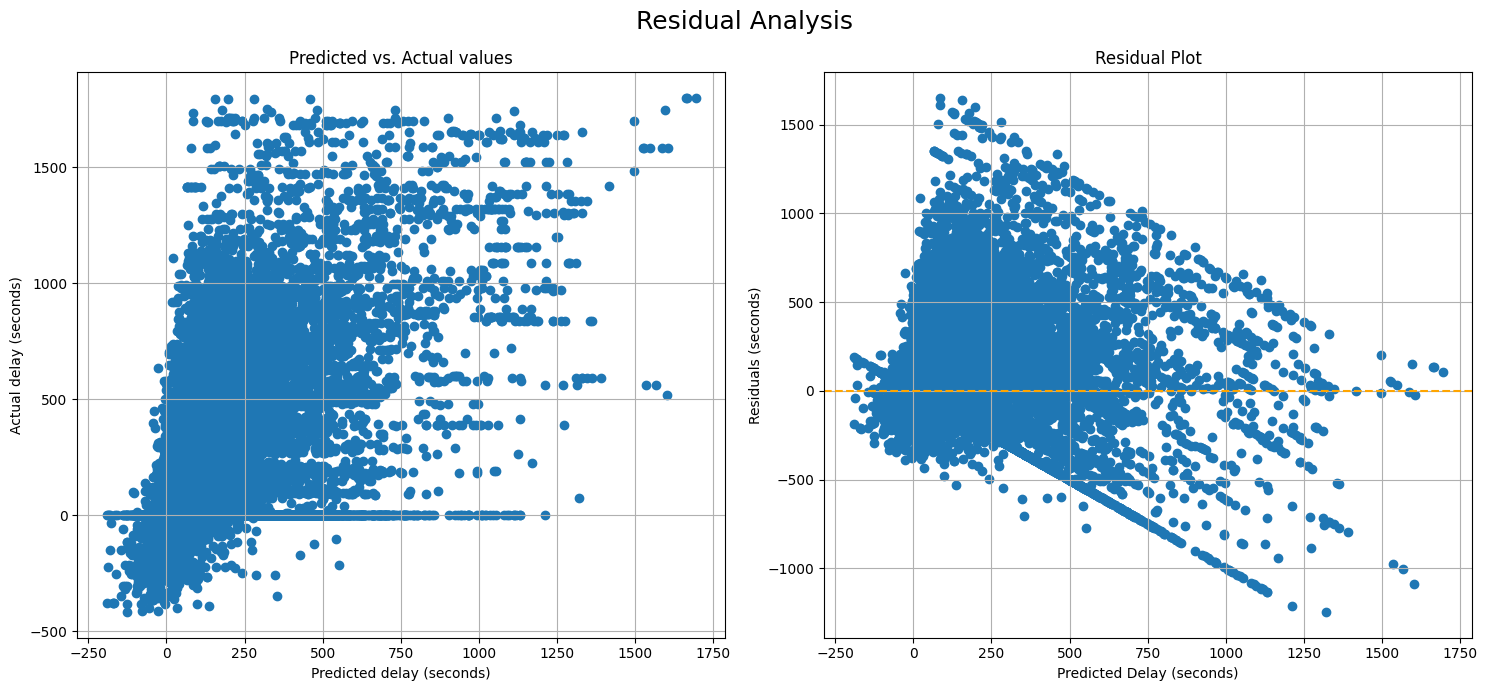

In [30]:
# Plot residuals
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Predicted vs. actual values
ax1.scatter(x=y_pred, y=y_val)
ax1.set_title('Predicted vs. Actual values')
ax1.set_xlabel('Predicted delay (seconds)')
ax1.set_ylabel('Actual delay (seconds)')
ax1.grid(True)

# Residuals
residuals = y_val - y_pred
ax2.scatter(x=y_pred, y=residuals)
ax2.set_title('Residual Plot')
ax2.set_xlabel('Predicted Delay (seconds)')
ax2.set_ylabel('Residuals (seconds)')
ax2.axhline(0, linestyle='--', color='orange')
ax2.grid(True)

fig.suptitle('Residual Analysis', fontsize=18)
fig.tight_layout()
fig.savefig(f'../images/residual_analysis.png', bbox_inches='tight')
plt.show()

Interpret plot

## Feature Importances

### MDI

### SHAP Plots

## Feature Pruning

## Retrain Model with Best Features

## Retune Parameters

## Final Model

### Evaluate with Test Set

### Make Prediction

In [33]:
# Save best model
joblib.dump(best_model, 'best_xgb_model.pkl')

NameError: name 'best_model' is not defined

## End